In [36]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from utils.data_preparation import naive_bayes_preprocessing
from models.naive_bayes import NaiveBayes

# Naive Bayes

In [37]:
processed_data, _ = naive_bayes_preprocessing(
    remove_stopwords=True, 
    use_bigrams=False
)
X_train, y_train = processed_data['train']
X_val, y_val = processed_data['validation']
X_test, y_test = processed_data['test']

In [38]:
nb = NaiveBayes(
    alpha=1.0,
    fit_prior=True,
)
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)
acc = nb.evaluate_acc(y_test, predictions)

In [39]:
print(f"Accuracy of Naive Bayes model: {acc:.4f}")

Accuracy of Naive Bayes model: 0.7945


## Grid Search

In [40]:
with open('out/nb_grid_search_results.pkl', 'rb') as handle:
    grid_search_results = pickle.load(handle)
print(grid_search_results.head())

   alpha  fit_prior  use_bigrams  remove_stopwords  val_accuracy
0    0.2      False         True              True        0.8355
1    0.5      False        False              True        0.8265
2    1.0      False        False              True        0.8265
3    0.1      False         True              True        0.8250
4    0.2       True         True              True        0.8215


## Results

Best params:
alpha                  0.2
fit_prior            False
use_bigrams           True
remove_stopwords      True
val_accuracy        0.8355
Name: 0, dtype: object
Test accuracy of Naive Bayes model: 0.8390
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       581
           1       0.86      0.89      0.88       695
           2       0.74      0.65      0.69       159
           3       0.87      0.77      0.82       275
           4       0.82      0.80      0.81       224
           5       0.79      0.41      0.54        66

    accuracy                           0.84      2000
   macro avg       0.82      0.74      0.77      2000
weighted avg       0.84      0.84      0.83      2000



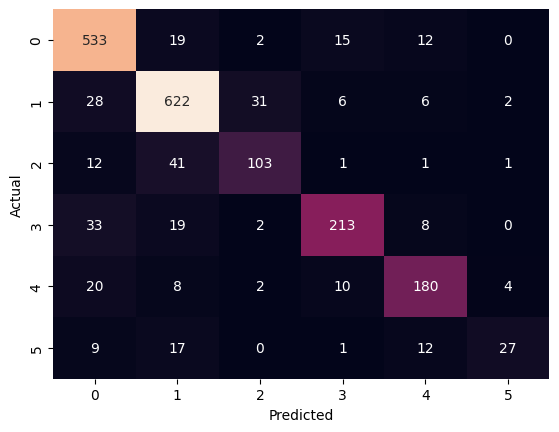

In [41]:
# take params from best model
best_params = grid_search_results.iloc[0]
print(f"Best params:\n{best_params}")

processed_data, vectorizer = naive_bayes_preprocessing(
    remove_stopwords=best_params['remove_stopwords'], 
    use_bigrams=best_params['use_bigrams']
)
X_train, y_train = processed_data['train']
X_test, y_test = processed_data['test']

nb = NaiveBayes(
    alpha=best_params['alpha'],
    fit_prior=best_params['fit_prior'],
)
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)
test_acc = nb.evaluate_acc(y_test, predictions)
print(f"Test accuracy of Naive Bayes model: {test_acc:.4f}")

print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
feature_names = vectorizer.get_feature_names_out()
class_log_probabilities = nb.feature_log_prob_
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

for i, class_probabilities in enumerate(class_log_probabilities):
    # sort features by their log prob
    sorted_features = np.argsort(class_probabilities)
    
    # get the top n feature
    top_features = sorted_features[-5:][::-1]
    top_scores = class_probabilities[top_features]
    top_scores = np.exp(top_scores)
    top_feature_names = feature_names[top_features]
    
    print(f"Class {i} ({class_names[i]}):", end=' ')
    for feature_name, score in zip(top_feature_names, top_scores):
        print(f"'{feature_name}' ({score:.4f})", end=' ')
    print()


Class 0 (sadness): 'feel' (0.0362) 'feeling' (0.0167) 'like' (0.0095) 'im' (0.0075) 'feel like' (0.0057) 
Class 1 (joy): 'feel' (0.0368) 'feeling' (0.0144) 'like' (0.0094) 'im' (0.0075) 'feel like' (0.0058) 
Class 2 (love): 'feel' (0.0221) 'feeling' (0.0090) 'like' (0.0073) 'im' (0.0046) 'feel like' (0.0044) 
Class 3 (anger): 'feel' (0.0270) 'feeling' (0.0134) 'like' (0.0071) 'im' (0.0063) 'feel like' (0.0047) 
Class 4 (fear): 'feel' (0.0241) 'feeling' (0.0148) 'im' (0.0064) 'like' (0.0051) 'just' (0.0034) 
Class 5 (surprise): 'feel' (0.0121) 'feeling' (0.0071) 'im' (0.0031) 'like' (0.0031) 'amazed' (0.0023) 


- the relatively small differences in probabilities between the same words across classes suggest that there is a significant overlap in how these words are used to express different emotions
- the presence of certain words with unique associations to an emotion (like 'amazed' for surprise) could be more discriminative and valuable for the classification task